In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df_cust= pd.read_csv(r"C:\Users\Jesse\OneDrive\Desktop\EcommerceAnalysis2024\files\customer_details.csv")
#Data  for df_ecom
df_ecom= pd.read_csv(r"C:\Users\Jesse\OneDrive\Desktop\EcommerceAnalysis2024\files\E-commerece sales data 2024.csv")
delete=df_ecom.columns[4]
df_ecom.drop(labels=delete,axis=1,inplace=True)
df_ecom=df_ecom.dropna(how='all')
# Data Cleanup for df_prod
df_prod= pd.read_csv(r"C:\Users\Jesse\OneDrive\Desktop\EcommerceAnalysis2024\files\product_details.csv")
drop_list=df_prod.columns[[2,3,5,6,8,15,17,18,19,20,21,22,23,24,26,27]].to_list()
df_prod.drop(labels=drop_list,axis=1,inplace=True)
df_prod['Selling Price']=df_prod['Selling Price'].replace('[\$,]','',regex=True)
df_prod=df_prod.rename(columns={'Uniqe Id':'Unique Id'})
df_prod['Selling Price']=pd.to_numeric(df_prod['Selling Price'],errors='coerce')
df_prod['Selling Price']=df_prod['Selling Price'].fillna(0).astype(int)
def convert_to_pounds(weight_str):
    # Check if the input is a string
    if isinstance(weight_str, str):
        # Regular expression to match the numeric part and the unit
        match = re.match(r'([\d.]+)\s*(pounds|ounces)', weight_str.strip())
        if match:
            try:
                value = float(match.group(1))
                unit = match.group(2)
                if unit == 'ounces':
                    # Convert ounces to pounds
                    return value * 0.0625
                else:
                    # Already in pounds
                    return value
            except ValueError:
                # Handle conversion errors
                return None
    # Return None for non-string values or invalid formats
    return None
df_prod['Shipping Weight (lbs)']=df_prod['Shipping Weight'].apply(convert_to_pounds)
df_prod.drop(labels='Shipping Weight',axis=1,inplace=True)
df_prod['Category']=df_prod['Category'].fillna('')
df_prod['CategorySplit']=df_prod['Category'].str.split('|')
df_prod['HeadCategory']=df_prod['CategorySplit'].apply(lambda x:x[0] if isinstance(x, list) and len(x) > 0 else None)
df_prod['HeadCategory']=df_prod['HeadCategory'].str.strip()
df_prod['SubCategory']=df_prod['CategorySplit'].apply(lambda x: '|'.join(x[1:]) if isinstance(x, list) and len(x) > 1 else None)
df_prod.drop(columns=['CategorySplit'], inplace=True)

In [7]:
words = ['Toys', 'Games']
contains_words=df_prod['Product Name'].str.contains('|'.join(words),case=False,na=False)
df_prod.loc[(df_prod['HeadCategory'] == '') & contains_words, 'HeadCategory'] = 'Toys & Games'
words2 = ['Clothes','Shoes','Jewelry']
contains_words2=df_prod['Product Name'].str.contains('|'.join(words2),case=False,na=False)
df_prod.loc[(df_prod['HeadCategory'] == '') & contains_words2, 'HeadCategory'] = 'Clothing, Shoes & Jewelry'
words3 = ['Home','Kitchen']
contains_words3=df_prod['Product Name'].str.contains('|'.join(words3),case=False,na=False)
df_prod.loc[(df_prod['HeadCategory'] == '') & contains_words3, 'HeadCategory'] = 'Home & Kitchen'
words4 = ['Sports']
contains_words4=df_prod['Product Name'].str.contains('|'.join(words4),case=False,na=False)
df_prod.loc[(df_prod['HeadCategory'] == '') & contains_words4, 'HeadCategory'] = 'Sports & Outdoors'
words5 = ['Patio','Lawn','Garden']
contains_words5=df_prod['Product Name'].str.contains('|'.join(words5),case=False,na=False)
df_prod.loc[(df_prod['HeadCategory'] == '') & contains_words5, 'HeadCategory'] = 'Patio, Lawn & Garden'

df_prod['HeadCategory']=df_prod['HeadCategory'].replace('','Unique')


ecom_prod=df_ecom.merge(df_prod,how='inner',left_on='product id',right_on='Unique Id')
topSelling=df_prod.groupby('HeadCategory').agg(T_Selling_Price=('Selling Price','sum')).sort_values(by='T_Selling_Price',ascending=False).head(10).reset_index()
topSelling=topSelling['HeadCategory'].unique().tolist()

ecom_prod=ecom_prod[ecom_prod['HeadCategory'].isin(topSelling)]
df_plot=ecom_prod.groupby(['HeadCategory','Interaction type']).size().reset_index(name='Interaction count')
df_plot


,HeadCategory,Interaction type,Interaction count
0,"Arts, Crafts & Sewing",like,18
1,"Arts, Crafts & Sewing",purchase,9
2,"Arts, Crafts & Sewing",view,17
3,Baby Products,like,13
4,Baby Products,purchase,14
5,Baby Products,view,15
6,"Clothing, Shoes & Jewelry",like,70
7,"Clothing, Shoes & Jewelry",purchase,46
8,"Clothing, Shoes & Jewelry",view,58
9,Home & Kitchen,like,56


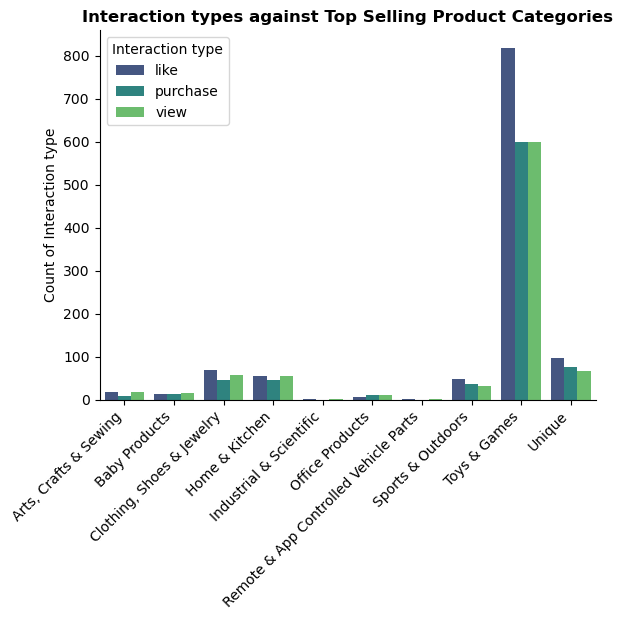

In [8]:
sns.barplot(data=df_plot,x='HeadCategory',y='Interaction count',hue='Interaction type',palette='viridis')
sns.despine()
plt.xticks(rotation=45,ha='right')
plt.ylabel('Count of Interaction type')
plt.xlabel('')
plt.title('Interaction types against Top Selling Product Categories',fontweight='bold')

plt.show()

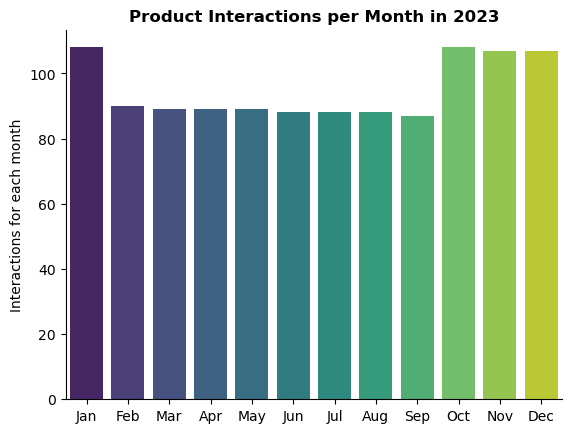

In [4]:
df_ecom['Time stamp'] = pd.to_datetime(df_ecom['Time stamp'], errors='coerce')
df_ecom.set_index('Time stamp',inplace=True)
monthTrends=df_ecom.resample('ME').size().to_frame(name='Interactions per month').reset_index()
monthTrends['Month']=monthTrends['Time stamp'].dt.strftime('%b')
sns.barplot(data=monthTrends,x='Month',y='Interactions per month',hue='Month',palette='viridis')
sns.despine()
plt.title('Product Interactions per Month in 2023',loc='center',fontweight='bold')
plt.ylabel('Interactions for each month')
plt.xlabel('')
plt.show()


In [9]:
user_data = ecom_prod.groupby('Interaction type').agg(
    T_Selling_Price=('Selling Price', 'sum'),
    M_Selling_Price=('Selling Price', 'mean'),
    Total_Interactions=('Interaction type', 'count')
)

interaction_types = user_data.index
# Create user profiles DataFrame with proper index
user_profiles = pd.DataFrame({
    'total_spending': [user_data.loc[interaction, 'T_Selling_Price'] * user_data.loc[interaction, 'Total_Interactions'] for interaction in interaction_types],
    'avg_spending': [user_data.loc[interaction, 'M_Selling_Price'] * user_data.loc[interaction, 'Total_Interactions'] for interaction in interaction_types]
}, index=interaction_types).reset_index()
user_profiles.rename(columns={'index': 'Interaction type'}, inplace=True)

user_profiles


,Interaction type,total_spending,avg_spending
0,like,42705429,37759.0
1,purchase,19927296,23808.0
2,view,22954745,26785.0


c:\Users\Jesse\anaconda3\envs\python_project1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


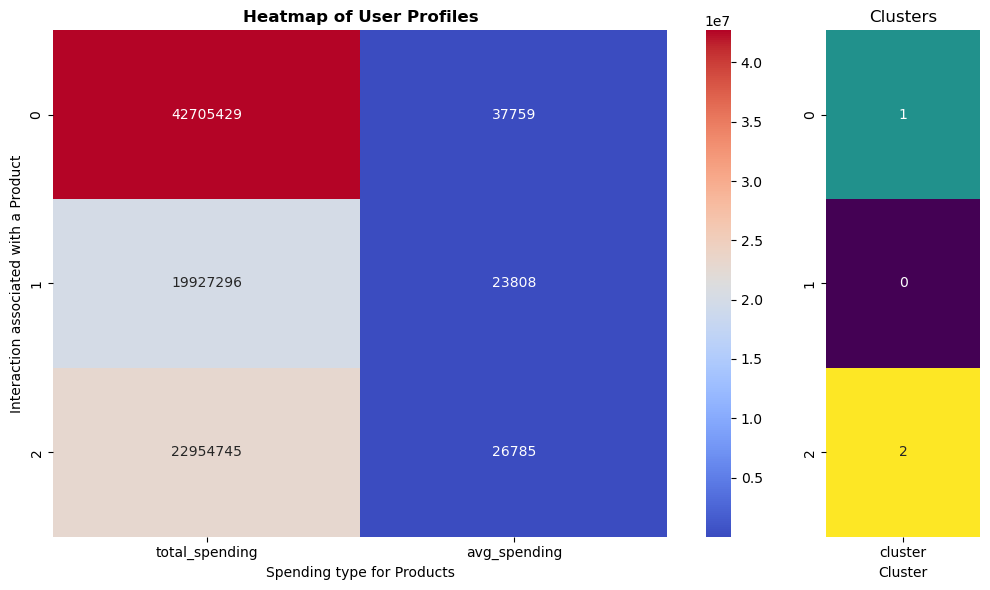

In [10]:

user_profiles_numeric = user_profiles.drop(columns=['Interaction type'])


# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_profiles[['total_spending', 'avg_spending']])

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_scaled)

# Add cluster labels back to the user_profiles DataFrame
user_profiles['cluster'] = kmeans.labels_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [5, 1]})

# Heatmap for total_spending and avg_spending
sns.heatmap(user_profiles[['total_spending', 'avg_spending']], annot=True, cmap='coolwarm', fmt='.0f', ax=ax1)
ax1.set_title('Heatmap of User Profiles', fontweight='bold')
ax1.set_ylabel('Interaction associated with a Product')
ax1.set_xlabel('Spending type for Products')

#color-coded side panel for the clusters
sns.heatmap(user_profiles[['cluster']], annot=True, cmap='viridis', cbar=False, ax=ax2)
ax2.set_title('Clusters')
ax2.set_ylabel('')
ax2.set_xlabel('Cluster')


plt.tight_layout()
plt.show()


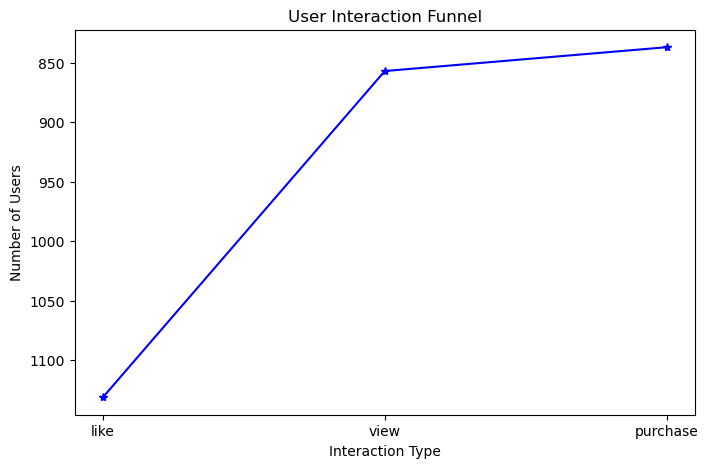

In [6]:

df_sorted = ecom_prod.sort_values(['user id', 'Time stamp'])

interaction_order = ['like', 'view', 'purchase']
# Count the number of each interaction type leading to a purchase
funnel = df_sorted.groupby('Interaction type')['user id'].nunique().reindex(interaction_order).reset_index()
funnel.columns = ['Interaction Type', 'Number of Users']
funnel

# Create a funnel plot
plt.figure(figsize=(8, 5))
plt.plot(funnel['Interaction Type'], funnel['Number of Users'], marker='*', linestyle='-', color='blue')
plt.title('User Interaction Funnel')
plt.xlabel('Interaction Type')
plt.ylabel('Number of Users')
plt.gca().invert_yaxis()  # To make it look like a funnel
plt.show()